In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data.csv
/kaggle/input/av-healthcare-analytics-ii/healthcare/test_data.csv
/kaggle/input/av-healthcare-analytics-ii/healthcare/sample_sub.csv
/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data_dictionary.csv


Janatahack: Healthcare Analytics II

Recent Covid-19 Pandemic has raised alarms over one of the most overlooked area to focus: Healthcare Management. While healthcare management has various use cases for using data science, patient length of stay is one critical parameter to observe and predict if one wants to improve the efficiency of the healthcare management in a hospital. 

This parameter helps hospitals to identify patients of high LOS risk (patients who will stay longer) at the time of admission. Once identified, patients with high LOS risk can have their treatment plan optimized to miminize LOS and lower the chance of staff/visitor infection. Also, prior knowledge of LOS can aid in logistics such as room and bed allocation planning.

Suppose you have been hired as Data Scientist of HealthMan – a not for profit organization dedicated to manage the functioning of Hospitals in a professional and optimal manner.
The task is to accurately predict the Length of Stay for each patient on case by case basis so that the Hospitals can use this information for optimal resource allocation and better functioning. The length of stay is divided into 11 different classes ranging from 0-10 days to more than 100 days.

Evaluation Metric
The evaluation metric for this hackathon is 100*Accuracy Score.

In [2]:
# standard libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline

In [3]:
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV,KFold
from sklearn.ensemble import RandomForestClassifier

In [4]:
from keras.utils import to_categorical

In [5]:
# read the data files here

train = pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data.csv')
test  = pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/test_data.csv')
sub   = pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/sample_sub.csv')
ddict = pd.read_csv('/kaggle/input/av-healthcare-analytics-ii/healthcare/train_data_dictionary.csv')

In [6]:
#explore the data files

train.shape,test.shape,sub.shape

((318438, 18), (137057, 17), (137057, 2))

In [7]:
ddict.head()

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital


In [8]:
train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [9]:
train.dtypes

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [10]:
train.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
patientid                               0
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [11]:
le = LabelEncoder()

In [12]:
train['Hospital_type_code'] = le.fit_transform(train['Hospital_type_code'])
train['Hospital_type_code'].unique()

array([2, 4, 1, 0, 5, 3, 6])

In [13]:
test['Hospital_type_code'] = le.fit_transform(test['Hospital_type_code'])
test['Hospital_type_code'].unique()

array([2, 0, 1, 4, 5, 3, 6])

In [14]:
train['Hospital_region_code'] = le.fit_transform(train['Hospital_region_code'])
train['Hospital_region_code'].unique()

array([2, 0, 1])

In [15]:
test['Hospital_region_code'] = le.fit_transform(test['Hospital_region_code'])
test['Hospital_region_code'].unique()

array([2, 0, 1])

In [16]:
train['Department'] = le.fit_transform(train['Department'])
train['Department'].unique()

array([3, 1, 2, 0, 4])

In [17]:
test['Department'] = le.fit_transform(test['Department'])
test['Department'].unique()

array([2, 1, 0, 3, 4])

In [18]:
train['Ward_Type'] = le.fit_transform(train['Ward_Type'])
train['Ward_Type'].unique()

array([2, 3, 1, 0, 4, 5])

In [19]:
test['Ward_Type'] = le.fit_transform(test['Ward_Type'])
test['Ward_Type'].unique()

array([3, 1, 2, 0, 4, 5])

In [20]:
train['Ward_Facility_Code'] = le.fit_transform(train['Ward_Facility_Code'])
train['Ward_Facility_Code'].unique()

array([5, 4, 3, 1, 0, 2])

In [21]:
test['Ward_Facility_Code'] = le.fit_transform(test['Ward_Facility_Code'])
test['Ward_Facility_Code'].unique()

array([0, 5, 3, 4, 2, 1])

In [22]:
train['Type of Admission'] = le.fit_transform(train['Type of Admission'])
train['Type of Admission'].unique()

array([0, 1, 2])

In [23]:
test['Type of Admission'] = le.fit_transform(test['Type of Admission'])
test['Type of Admission'].unique()

array([0, 1, 2])

In [24]:
train['Severity of Illness'] = le.fit_transform(train['Severity of Illness'])
train['Severity of Illness'].unique()

array([0, 2, 1])

In [25]:
test['Severity of Illness'] = le.fit_transform(test['Severity of Illness'])
test['Severity of Illness'].unique()

array([2, 0, 1])

In [26]:
test.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,2,3,2,3,2,3,0,2.0,17006,2.0,0,2,2,71-80,3095.0
1,318440,29,0,4,0,2,2,3,5,2.0,17006,2.0,1,2,4,71-80,4018.0
2,318441,26,1,2,1,3,2,1,3,4.0,17006,2.0,0,2,3,71-80,4492.0
3,318442,6,0,6,0,3,2,1,5,2.0,17006,2.0,1,2,3,71-80,4173.0
4,318443,28,1,11,0,2,2,2,5,2.0,17006,2.0,1,2,4,71-80,4161.0


In [27]:
sub.head()

,case_id,Stay
0,318439,0-10
1,318440,0-10
2,318441,0-10
3,318442,0-10
4,318443,0-10


In [28]:
sub.dtypes

case_id     int64
Stay       object
dtype: object

In [29]:
test.dtypes

case_id                                int64
Hospital_code                          int64
Hospital_type_code                     int64
City_Code_Hospital                     int64
Hospital_region_code                   int64
Available Extra Rooms in Hospital      int64
Department                             int64
Ward_Type                              int64
Ward_Facility_Code                     int64
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                      int64
Severity of Illness                    int64
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
dtype: object

In [30]:
test.isnull().sum()

case_id                                 0
Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Hospital_region_code                    0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                              35
patientid                               0
City_Code_Patient                    2157
Type of Admission                       0
Severity of Illness                     0
Visitors with Patient                   0
Age                                     0
Admission_Deposit                       0
dtype: int64

In [31]:
train['Bed Grade'].unique()

array([ 2.,  3.,  4.,  1., nan])

In [32]:
train['City_Code_Patient'].unique()

array([ 7.,  8.,  2.,  5.,  6.,  3.,  4.,  1.,  9., 14., nan, 25., 15.,
       12., 10., 28., 24., 23., 20., 11., 13., 21., 18., 16., 26., 27.,
       22., 19., 31., 34., 32., 30., 29., 37., 33., 35., 36., 38.])

In [33]:
test['Bed Grade'].unique()

array([ 2.,  4.,  3.,  1., nan])

In [34]:
test['City_Code_Patient'].unique()

array([ 2., nan,  8.,  7., 14.,  1., 10., 12.,  5., 15.,  4., 21.,  6.,
        9., 28., 34., 23., 22.,  3., 30., 20., 11., 26., 13., 18., 27.,
       19., 25., 31., 16., 29., 24., 33., 32., 37., 38., 36., 35.])

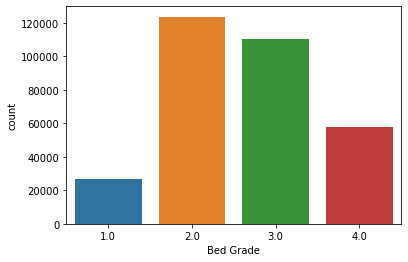

In [35]:
sns.countplot(train['Bed Grade'])

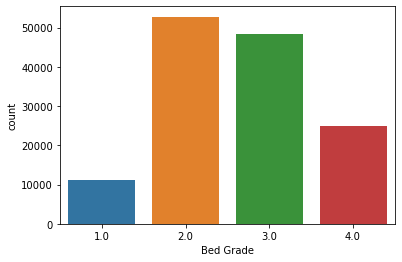

In [36]:
sns.countplot(test['Bed Grade'])

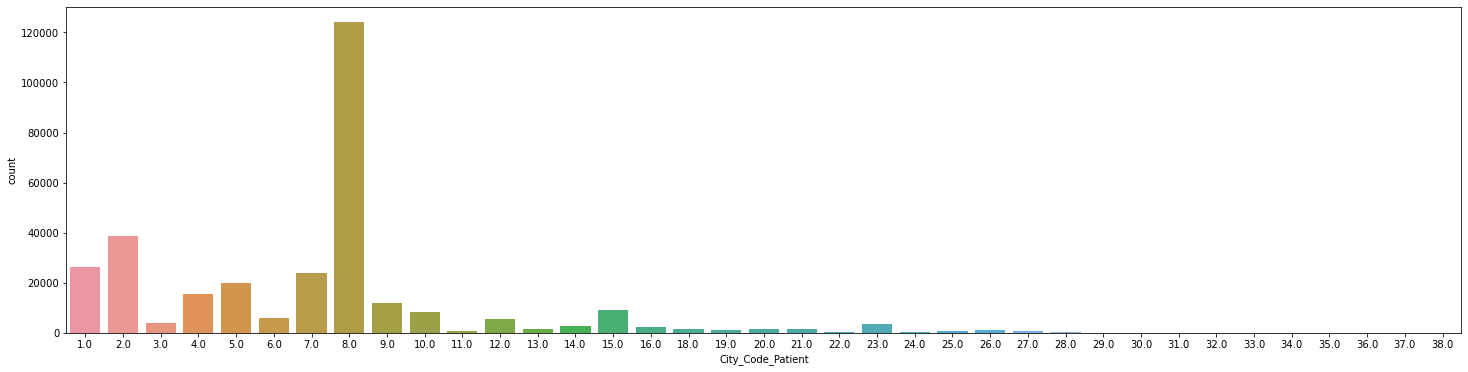

In [37]:
fig = plt.figure(figsize=(25,6))
sns.countplot(train['City_Code_Patient'])

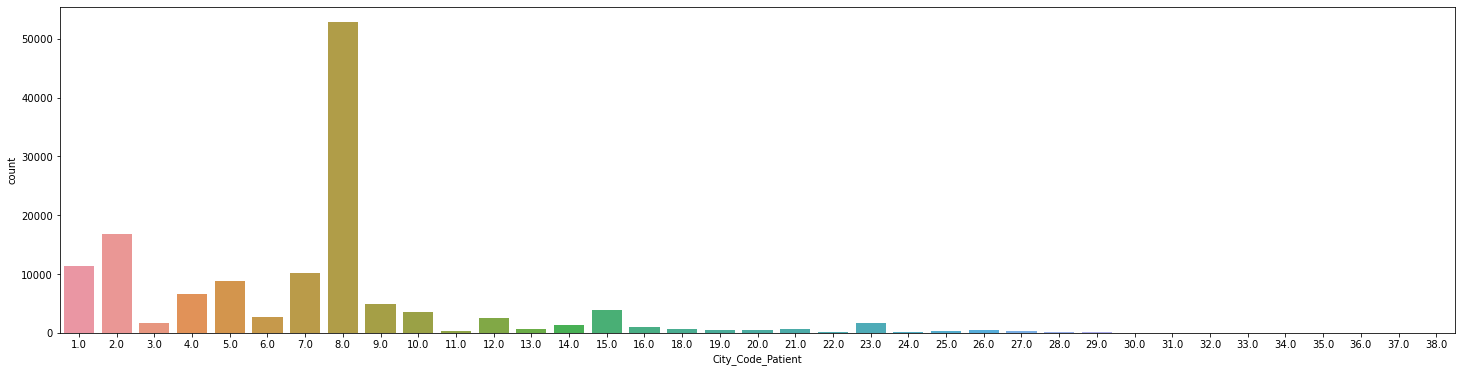

In [38]:
fig = plt.figure(figsize=(25,6))
sns.countplot(test['City_Code_Patient'])

In [39]:
bedgrad_meantr     = round(train['Bed Grade'].mean(),1)
citycodepat_meantr = round(train['City_Code_Patient'].mean(),1)

bedgrad_meants     = round(test['Bed Grade'].mean(),1)
citycodepat_meants = round(test['City_Code_Patient'].mean(),1)

print(bedgrad_meantr,citycodepat_meantr,bedgrad_meants,citycodepat_meants)

2.6 7.3 2.6 7.2


In [40]:
#impute the missing values with mean 

train['Bed Grade']            = train['Bed Grade'].fillna(bedgrad_meantr)
train['City_Code_Patient']    = train['City_Code_Patient'].fillna(citycodepat_meantr)
test['Bed Grade']             = test['Bed Grade'].fillna(bedgrad_meants)
test ['City_Code_Patient']    = test['City_Code_Patient'].fillna(citycodepat_meants)

In [41]:
train['Bed Grade']            = round(train['Bed Grade'],1)
train['City_Code_Patient']    = round(train['City_Code_Patient'],1)
test['Bed Grade']             = round(test['Bed Grade'],1)
test['City_Code_Patient']     = round(test['City_Code_Patient'],1)

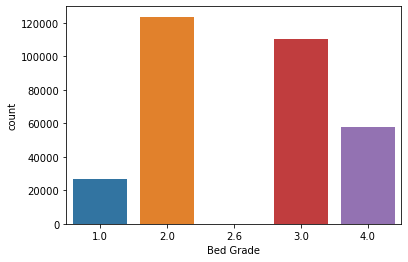

In [42]:
sns.countplot(train['Bed Grade'])

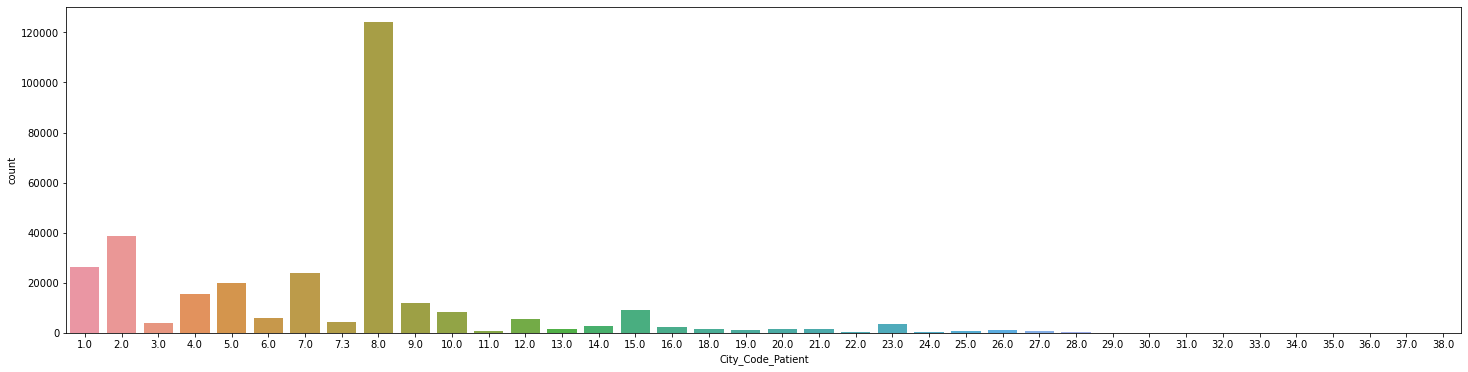

In [43]:
fig = plt.figure(figsize=(25,6))
sns.countplot(train['City_Code_Patient'])

In [44]:
train['Age'].unique()

array(['51-60', '71-80', '31-40', '41-50', '81-90', '61-70', '21-30',
       '11-20', '0-10', '91-100'], dtype=object)

In [45]:
train['Stay'].unique()

array(['0-10', '41-50', '31-40', '11-20', '51-60', '21-30', '71-80',
       'More than 100 Days', '81-90', '61-70', '91-100'], dtype=object)

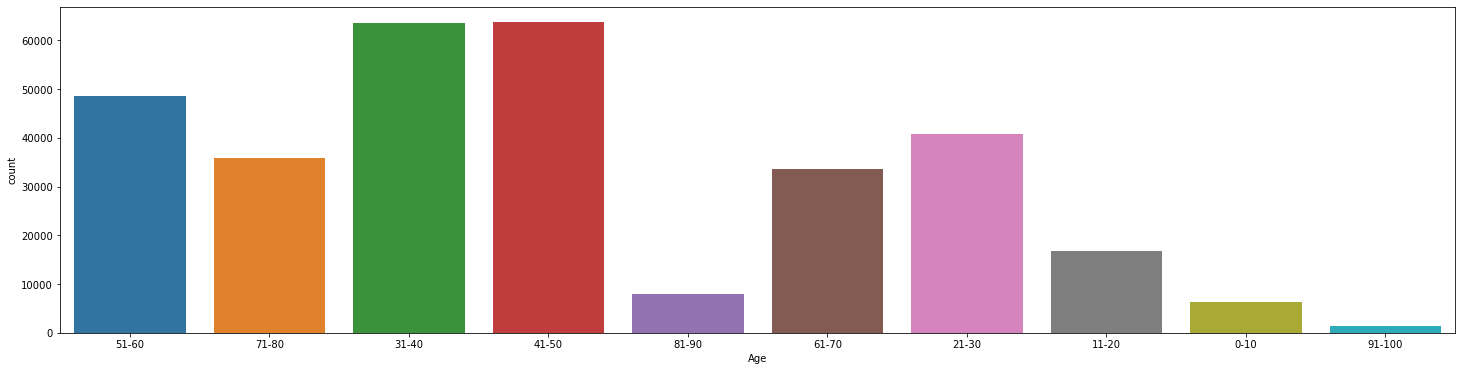

In [46]:
fig = plt.figure(figsize=(25,6))
sns.countplot(train['Age'])

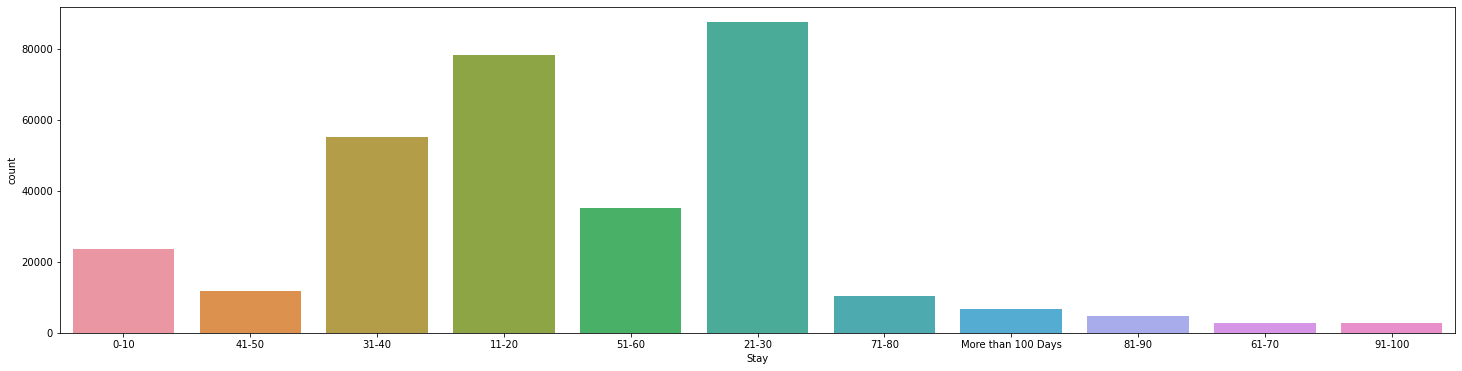

In [47]:
fig = plt.figure(figsize=(25,6))
sns.countplot(train['Stay'])

In [48]:
def _mapRangeNum(ran) :
    
    if ran == '0-10' :
        return 0
    elif ran == '11-20' :
        return 1
    elif ran == '21-30' :
        return 2
    elif ran == '31-40' :
        return 3
    elif ran == '41-50' :
        return 4
    elif ran == '51-60' :
        return 5
    elif ran == '61-70' :
        return 6
    elif ran == '71-80' :
        return 7
    elif ran == '81-90' :
        return 8
    elif ran == '91-100' :
        return 9
    elif ran == 'More than 100 Days' :
        return 10   
    

In [49]:
def _InversemapRangeNum(ran) :
    
    if ran == 0 :
        return '0-10'
    elif ran == 1 :
        return "11-20"
    elif ran == 2 :
        return '21-30'
    elif ran == 3:
        return '31-40' 
    elif ran == 4 :
        return '41-50'
    elif ran == 5 :
        return '51-60'
    elif ran == 6 :
        return '61-70'
    elif ran == 7 :
        return '71-80'
    elif ran == 8 :
        return '81-90'
    elif ran == 9 :
        return '91-100'
    elif ran == 10 :
        return 'More than 100 Days'

In [50]:
_mapRangeNum('11-20')

1

In [51]:
_InversemapRangeNum(1)

'11-20'

In [52]:
train['Age']  = train['Age'].apply(lambda x : _mapRangeNum(x))
train['Stay'] = train['Stay'].apply(lambda x : _mapRangeNum(x))

In [53]:
test['Age']  = test['Age'].apply(lambda x : _mapRangeNum(x))

In [54]:
le = LabelEncoder()

In [55]:
train.head()  # Now one hot encoded

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,2,3,2,3,3,2,5,2.0,31397,7.0,0,0,2,5,4911.0,0
1,2,2,2,5,2,2,3,3,5,2.0,31397,7.0,1,0,2,5,5954.0,4
2,3,10,4,1,0,2,1,3,4,2.0,31397,7.0,1,0,2,5,4745.0,3
3,4,26,1,2,1,2,3,2,3,2.0,31397,7.0,1,0,2,5,7272.0,4
4,5,26,1,2,1,2,3,3,3,2.0,31397,7.0,1,0,2,5,5558.0,4


In [56]:
test.head()   # one hot encoded

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit
0,318439,21,2,3,2,3,2,3,0,2.0,17006,2.0,0,2,2,7,3095.0
1,318440,29,0,4,0,2,2,3,5,2.0,17006,2.0,1,2,4,7,4018.0
2,318441,26,1,2,1,3,2,1,3,4.0,17006,2.0,0,2,3,7,4492.0
3,318442,6,0,6,0,3,2,1,5,2.0,17006,2.0,1,2,3,7,4173.0
4,318443,28,1,11,0,2,2,2,5,2.0,17006,2.0,1,2,4,7,4161.0


In [57]:
train.columns

Index(['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit', 'Stay'],
      dtype='object')

In [58]:
# Model building - step 1 extract X,y from dataset

X = train[['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit']].values

Xtst = test[['case_id', 'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
       'Hospital_region_code', 'Available Extra Rooms in Hospital',
       'Department', 'Ward_Type', 'Ward_Facility_Code', 'Bed Grade',
       'patientid', 'City_Code_Patient', 'Type of Admission',
       'Severity of Illness', 'Visitors with Patient', 'Age',
       'Admission_Deposit']].values

y = train['Stay']

X, Xtst = np.array(X), np.array(Xtst)
y = np.array(y)

X.shape,y.shape,Xtst.shape

((318438, 17), (318438,), (137057, 17))

In [59]:
X

array([[1.00000e+00, 8.00000e+00, 2.00000e+00, ..., 2.00000e+00,
        5.00000e+00, 4.91100e+03],
       [2.00000e+00, 2.00000e+00, 2.00000e+00, ..., 2.00000e+00,
        5.00000e+00, 5.95400e+03],
       [3.00000e+00, 1.00000e+01, 4.00000e+00, ..., 2.00000e+00,
        5.00000e+00, 4.74500e+03],
       ...,
       [3.18436e+05, 7.00000e+00, 0.00000e+00, ..., 3.00000e+00,
        7.00000e+00, 4.23500e+03],
       [3.18437e+05, 1.10000e+01, 1.00000e+00, ..., 5.00000e+00,
        1.00000e+00, 3.76100e+03],
       [3.18438e+05, 1.90000e+01, 0.00000e+00, ..., 2.00000e+00,
        1.00000e+00, 4.75200e+03]])

In [60]:
y

array([0, 4, 3, ..., 1, 1, 0])

In [ ]:
y_cat = to_categorical(y)

In [ ]:
y_cat

In [ ]:
mms = MinMaxScaler()

Xscale  = mms.fit_transform(X)
Xtscale = mms.fit_transform(Xtst)

In [61]:
sc = StandardScaler()

Xscale  = sc.fit_transform(X)
Xtscale = sc.fit_transform(Xtst)

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(Xscale,y_cat,stratify=y,test_size =0.25,random_state=11,shuffle=True)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

In [62]:
X_train,X_val,y_train,y_val = train_test_split(Xscale,y,stratify=y,test_size =0.25,random_state=11,shuffle=True)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

((238828, 17), (79610, 17), (238828,), (79610,))

In [ ]:
# model building - split the data to train and validation

X_train,X_val,y_train,y_val = train_test_split(X,y,stratify=y,test_size =0.25,random_state=11,shuffle=True)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

In [ ]:
lr = LogisticRegression(max_iter =10000)

lr.fit(X_train,y_train)
lrp = lr.predict(X_val)

ac = 100 * accuracy_score(y_val,lrp)
print('Accuracy Score ', ac)

In [ ]:
# hyper parameter tunning for LightGBM

SEED = 4 
NFOLDS = 2
kf = KFold(n_splits= NFOLDS, shuffle=False)

parameters = {
          'num_leaves': np.arange(100,500,100),
          'min_child_weight': np.arange(0.01,1,0.01),
    }

model = lgb.LGBMClassifier()

RSCV = RandomizedSearchCV(model,parameters,scoring='accuracy',cv=kf.split(X_train),n_iter=30,verbose=50)
RSCV.fit(X_train,y_train)

parameters = {
          'feature_fraction': np.arange(0.1,0.4,0.01),
          'bagging_fraction':np.arange(0.3,0.5,0.01),
          'min_data_in_leaf': np.arange(100,1500,10),
    }

RSCV = RandomizedSearchCV(RSCV.best_estimator_,parameters,scoring='accuracy',cv=kf.split(X_train),n_iter=30,verbose=50)
RSCV.fit(X_train,y_train)

In [65]:
#lg = lgb.LGBMClassifier(boosting_type ='dart',feature_fraction=0.9)

lg = lgb.LGBMClassifier(n_estimators=480,num_leaves=200,max_depth=20)

lg.fit(X_train,y_train)
lgp = lg.predict(X_val)

ac = 100 * accuracy_score(y_val,lgp)
print('Accuracy Score ', ac)

Accuracy Score  42.72830046476573


In [ ]:
acc = {}   # n_estimators

for nest in tqdm(range(100,1001,20),desc = 'n_estimators') :
    
    lg = lgb.LGBMClassifier(n_estimators = nest)

    lg.fit(X_train,y_train)
    lgp = lg.predict(X_val)

    ac = 100 * accuracy_score(y_val,lgp)
    acc[nest] = ac

In [ ]:
nleaves = {}   # n_estimators

for nl in tqdm(range(10,31,1),desc = 'num_leaves') :
    
    lg = lgb.LGBMClassifier(n_estimators = 480,num_leaves=nl)

    lg.fit(X_train,y_train)
    lgp = lg.predict(X_val)

    ac = 100 * accuracy_score(y_val,lgp)
    nleaves[nl] = ac

In [ ]:
aldf = pd.DataFrame.from_dict(nleaves,orient='index',columns =['LEAVES'])

sns.lineplot(aldf.index,aldf.LEAVES)
aldf[aldf.LEAVES == aldf.LEAVES.max()]

# max num_leaves @ 25 42.909182

In [ ]:
mdepth = {}   # max_depth

for md in tqdm(range(1,10,2),desc = 'max_depth') :
    
    lg = lgb.LGBMClassifier(n_estimators = 480,num_leaves=25,max_depth=md)

    lg.fit(X_train,y_train)
    lgp = lg.predict(X_val)

    ac = 100 * accuracy_score(y_val,lgp)
    mdepth[md] = ac

In [63]:
mdepth = {}   # max_depth

for md in tqdm(range(20,51,4),desc = 'max_depth') :
    
    lg = lgb.LGBMClassifier(n_estimators = 480,num_leaves=25,max_depth=md)

    lg.fit(X_train,y_train)
    lgp = lg.predict(X_val)

    ac = 100 * accuracy_score(y_val,lgp)
    mdepth[md] = ac

max_depth: 100%|██████████| 8/8 [18:02<00:00, 135.33s/it]


,DEPTH
20,42.909182
24,42.909182
28,42.909182
32,42.909182
36,42.909182
40,42.909182
44,42.909182
48,42.909182


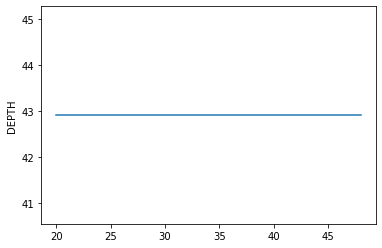

In [64]:
mddf = pd.DataFrame.from_dict(mdepth,orient='index',columns =['DEPTH'])

sns.lineplot(mddf.index,mddf.DEPTH)
mddf[mddf.DEPTH == mddf.DEPTH.max()]

# max num_leaves @ 25 42.909182

In [ ]:
accdf = pd.DataFrame.from_dict(acc,orient='index',columns =['ACC'])

sns.lineplot(accdf.index,accdf.ACC)
accdf[accdf.ACC == accdf.ACC.max()]

# max n_estimators @ 480 42.897977

In [ ]:
lg = lgb.LGBMClassifier(boosting_type = 'dart')

lg.fit(X_train,y_train)
lgp = lg.predict(X_val)

ac = 100 * accuracy_score(y_val,lgp)
print('Accuracy Score ', ac)

In [ ]:
cb = CatBoostClassifier()

cb.fit(X_train,y_train)
cbp = cb.predict(X_val)

ac = 100 * accuracy_score(y_val,cbp)
print('Accuracy Score ', ac)

In [ ]:
import xgboost as xgb
xg = xgb.XGBClassifier(n_estimators=300)

xg.fit(X_train,y_train)
xgp = xg.predict(X_val)

ac = 100 * accuracy_score(y_val,xgp)
print('Accuracy Score ', ac)

In [ ]:
rf = RandomForestClassifier(n_estimators=300)

rf.fit(X_train,y_train)
rfp = rf.predict(X_val)

ac = 100 * accuracy_score(y_val,rfp)
print('Accuracy Score ', ac)

In [ ]:
pred = lr.predict(Xtscale)
pred

In [66]:
pred = lg.predict(Xtscale)
pred

array([2, 5, 2, ..., 2, 1, 5])

In [ ]:
pred = cb.predict(Xtscale)
pred

In [ ]:
pred = xg.predict(Xtscale)
pred

In [ ]:
pred = rf.predict(Xtscale)
pred

In [67]:
tdf = pd.DataFrame(pred,columns =['Stay'])
tdf.Stay.unique()

array([ 2,  5,  3,  1,  0,  4, 10,  7,  8,  9,  6])

In [68]:
stay=[]

for p in pred :
    stay.append(_InversemapRangeNum(p))

stay

['21-30',
 '51-60',
 '21-30',
 '21-30',
 '51-60',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '31-40',
 '11-20',
 '21-30',
 '31-40',
 '21-30',
 '31-40',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '51-60',
 '21-30',
 '31-40',
 '51-60',
 '11-20',
 '21-30',
 '21-30',
 '21-30',
 '31-40',
 '11-20',
 '21-30',
 '51-60',
 '31-40',
 '51-60',
 '21-30',
 '0-10',
 '21-30',
 '21-30',
 '51-60',
 '11-20',
 '0-10',
 '21-30',
 '21-30',
 '11-20',
 '21-30',
 '21-30',
 '21-30',
 '31-40',
 '41-50',
 'More than 100 Days',
 'More than 100 Days',
 '51-60',
 '51-60',
 '51-60',
 '51-60',
 '21-30',
 '31-40',
 '21-30',
 '11-20',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '11-20',
 '11-20',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '11-20',
 '21-30',
 '21-30',
 '21-30',
 '11-20',
 '21-30',
 '21-30',
 '21-30',
 '51-60',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '21-30',
 '31-40',
 '21-30',
 '21-30',
 '21-30',
 '11-2

In [69]:
caseid = test['case_id']
caseid

0         318439
1         318440
2         318441
3         318442
4         318443
           ...  
137052    455491
137053    455492
137054    455493
137055    455494
137056    455495
Name: case_id, Length: 137057, dtype: int64

In [70]:
caseid = pd.DataFrame(caseid,columns=['case_id'])
stay   = pd.DataFrame(stay,columns =['Stay'])

outp = pd.concat([caseid,stay],axis=1)
outp

,case_id,Stay
0,318439,21-30
1,318440,51-60
2,318441,21-30
3,318442,21-30
4,318443,51-60
...,...,...
137052,455491,21-30
137053,455492,0-10
137054,455493,21-30
137055,455494,11-20


In [71]:
outp[outp.case_id == 318957]

,case_id,Stay
518,318957,71-80


In [72]:
outp.Stay.unique()

array(['21-30', '51-60', '31-40', '11-20', '0-10', '41-50',
       'More than 100 Days', '71-80', '81-90', '91-100', '61-70'],
      dtype=object)

In [ ]:
outp.isnull().sum()

In [ ]:
outp.dtypes

In [ ]:
outp.Stay = outp.Stay.astype(str)

In [ ]:
outp.to_excel('logi01.xlsx',index=False)

In [ ]:
tmp = pd.read_excel('logi01.xlsx',dtype ={'Stay': str})
tmp

In [ ]:
outp.to_csv('lg96-04.csv',index=False)

In [ ]:
Xscale.shape,Xtscale.shape,y_cat.shape

In [ ]:
#reshape X,y for LSTM and GRU model

Xscale  = Xscale.reshape(len(Xscale),-1,1)
Xtscale = Xtscale.reshape(len(Xtscale),-1,1)

Xscale.shape,Xtscale.shape,y.shape

In [ ]:
y

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(Xscale,y,stratify=y,test_size =0.25,random_state=11,shuffle=True)

X_train.shape,X_val.shape,y_train.shape,y_val.shape

In [ ]:
y_train

In [ ]:
y_val

In [ ]:
y_train = to_categorical(y_train)
y_val   = to_categorical(y_val)
y_train.shape,y_val.shape

In [ ]:
# deep learning RNN / LSTM models

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [ ]:
#RNN model

model = Sequential()
model.add(Dense(units=1024,activation ='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1024,activation ='relu'))
model.add(Dropout(0.4))
model.add(Dense(units = 11,activation ='softmax'))

adam = Adam(lr =1e-5)

model.compile(optimizer = adam, loss = 'categorical_crossentropy',metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=80, verbose=0, mode='min')

mcp_save = ModelCheckpoint('rnn.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


history = model.fit(X_train,y_train, epochs = 1000,batch_size = 128,validation_data= (X_val,y_val),callbacks=[earlyStopping,mcp_save],verbose=1)

model.summary()


In [ ]:
#GRU model

model = Sequential()
model.add(GRU(units=1024,return_sequences=True,input_shape = (X_train.shape[1],1),activation ='relu'))
model.add(Dropout(0.3))
model.add(GRU(units=1024,activation ='relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 11,activation ='softmax'))

adam = Adam(lr =1e-5)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

mcp_save = ModelCheckpoint('GRU.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


history = model.fit(X_train,y_train, epochs = 50,batch_size = 1024,validation_data= (X_val,y_val),callbacks=[earlyStopping,mcp_save],verbose=1)

model.summary()

In [ ]:
#LSTM model

model = Sequential()
model.add(LSTM(units=1024,return_sequences=True,input_shape = (X_train.shape[1],1),activation ='relu'))
model.add(Dropout(0.3))
model.add(LSTM(units=1024,activation ='relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 11,activation ='softmax'))

adam = Adam(lr =1e-5)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')

mcp_save = ModelCheckpoint('LSTM.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')


history = model.fit(X_train,y_train, epochs = 50,batch_size = 1024,validation_data= (X_val,y_val),callbacks=[earlyStopping,mcp_save],verbose=1)

model.summary()

In [ ]:
history = model.fit(X_train,y_train, epochs = 15,batch_size = 1024,validation_data= (X_val,y_val),callbacks=[earlyStopping,mcp_save],verbose=1)

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights("LSTM.hdf5")

In [ ]:
pred = model.predict(Xtscale)
pred

In [ ]:
predict_class = np.argmax(pred, axis=1)
predict_class = predict_class.tolist()
predict_class

In [ ]:
stay=[]

for p in predict_class :
    stay.append(_InversemapRangeNum(p))

stay

In [ ]:
outp.to_csv('LSTM01.csv',index=False)